In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math 
from scipy.integrate import odeint
import networkx as nx
import powerlaw
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics.SIRModel as SIR

ModuleNotFoundError: No module named 'powerlaw'

In [139]:
# Exercise 1.1
beta = 0.3
gamma = 0.1
mu = 0.05
t = 200

def gillespies_sir(t, S0, I0, R0, beta, gamma, mu):
    times = []
    S_list = []
    I_list = []
    R_list = []
    
    t0 = 0
    S = S0
    I = I0
    R = R0

    while t0 < t and (S + I + R) > 0:
        N = S + I + R
        r_infect = beta * S * I / N
        r_birth = mu * N
        r_recover = gamma * I
        r_deathS = mu * S
        r_deathI = mu * I
        r_deathR = mu * R

        rate0 = r_infect + r_birth + r_recover + r_deathS + r_deathI + r_deathR

        if rate0 <= 0.0:
            break

        u1 = random.uniform(0, 1.0)
        dt = -math.log(u1) / rate0
        t0 += dt
        if t0 > t:
            break

        u2 = random.uniform(0, 1.0) * rate0
        if u2 < r_infect:
            if S > 0:
                S -= 1
                I += 1
        elif u2 < r_infect + r_birth:
            S += 1
        elif u2 < r_infect + r_birth + r_recover:
            if I > 0:
                I -= 1
                R += 1
        elif u2 < r_infect + r_birth + r_recover + r_deathS:
            if S > 0:
                S -= 1
        elif u2 < r_infect + r_birth + r_recover + r_deathS + r_deathI:
            if I > 0:
                I -= 1
        else:
            if R > 0:
                R -= 1   

        times.append(t0)
        S_list.append(S)
        I_list.append(I)
        R_list.append(R)

    return times, S_list, I_list, R_list



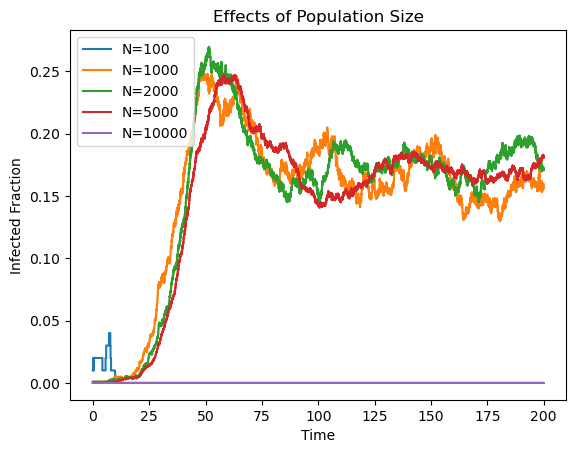

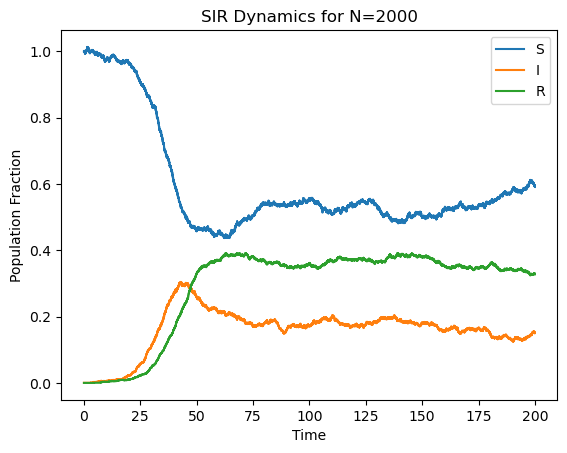

In [150]:
# PLotting:
N_vals = [100, 1000, 2000, 5000, 10000]

# Bonus part: controlling noise levels (somewhat?)
# Plot infected fractions for different values of N: more random for smaller N
for N in N_vals:
    S0, I0, R0 = N - 1, 1, 0
    times, S, I, R = gillespies_sir(t, S0, I0, R0, beta, gamma, mu)
    fracI = np.array(I) / N # normalise since different Ns
    plt.step(times, fracI, where='post', label=f'N={N}')
    
plt.title('Effects of Population Size')
plt.xlabel('Time')
plt.ylabel('Infected Fraction')
plt.legend()
plt.show()

# Choosing N=2000 as reasonable pop size based on the plot
N = 2000
S0, I0, R0 = N - 1, 1, 0
times, S, I, R = gillespies_sir(t, S0, I0, R0, beta, gamma, mu)
fracS, fracI, fracR = np.array(S) / N, np.array(I) / N, np.array(R) / N #still doing fracrtions for consistency 
plt.step(times, fracS, where='post', label='S')
plt.step(times, fracI, where='post', label='I')
plt.step(times, fracR, where='post', label='R')
plt.title('SIR Dynamics for N=2000')
plt.xlabel('Time')
plt.ylabel('Population Fraction')
plt.legend()
plt.show()


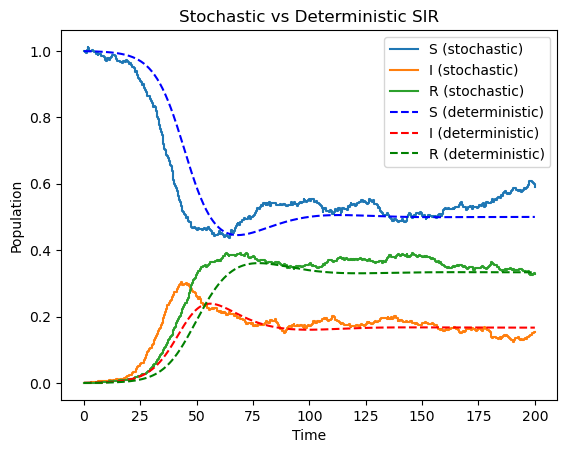

In [151]:
# Equivalent deterministic ODE:
def det_sir(y, t, beta, gamma, mu):
    S, I, R = y
    N = S + I + R
    dS = mu * N - beta * S * I / N - mu * S
    dI = beta * S * I / N - gamma * I - mu * I
    dR = gamma * I - mu * R
    return dS, dI, dR

def integrate_det_sir(y0, t, beta, gamma, mu):
    results = odeint(det_sir, y0, t, args=(beta, gamma, mu))
    S, I, R = results.T
    return S, I, R

# make commong time grid 
t_grid = np.linspace(0, t, 500)

# move stoch onto the common grid
S_s = np.interp(t_grid, times, np.array(S)/N)
I_s = np.interp(t_grid, times, np.array(I)/N)
R_s = np.interp(t_grid, times, np.array(R)/N)

# Plot together to compare:
plt.step(t_grid, S_s, where='post', label='S (stochastic)')
plt.step(t_grid, I_s, where='post', label='I (stochastic)')
plt.step(t_grid, R_s, where='post', label='R (stochastic)')
S_det, I_det, R_det = integrate_det_sir([S0, I0, R0], t_grid, beta, gamma, mu)
plt.plot(t_grid, S_det/N, 'b--', label='S (deterministic)')
plt.plot(t_grid, I_det/N, 'r--', label='I (deterministic)')
plt.plot(t_grid, R_det/N, 'g--', label='R (deterministic)')
plt.title('Stochastic vs Deterministic SIR')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()




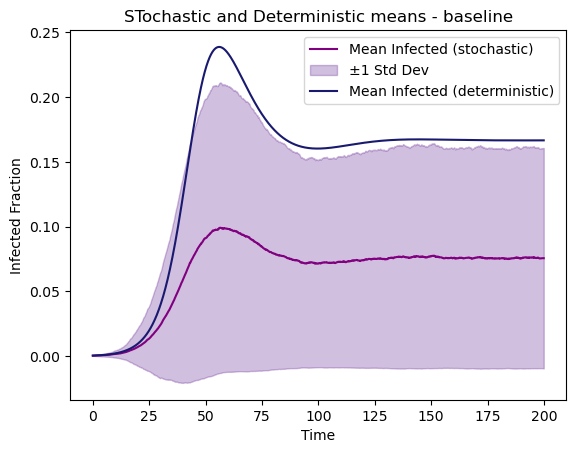

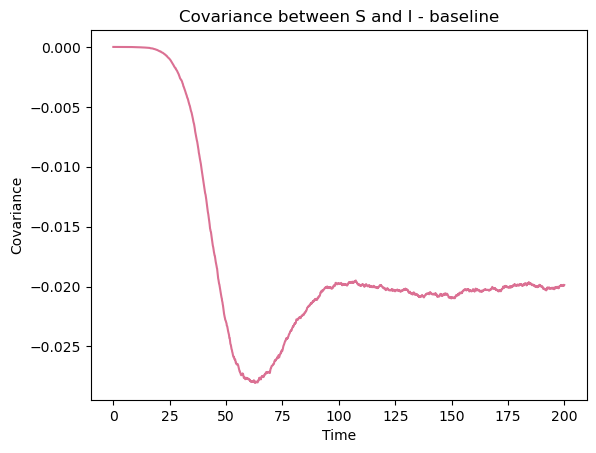

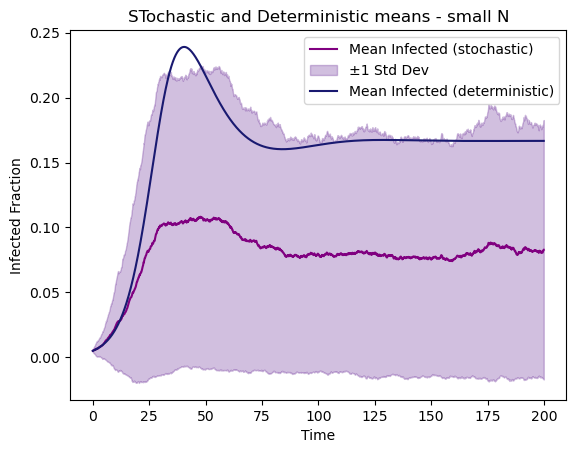

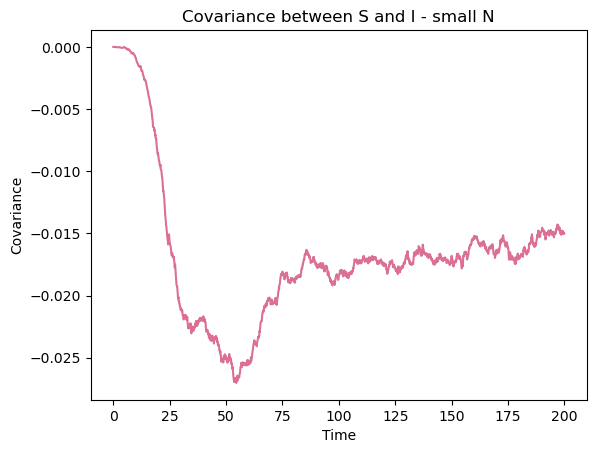

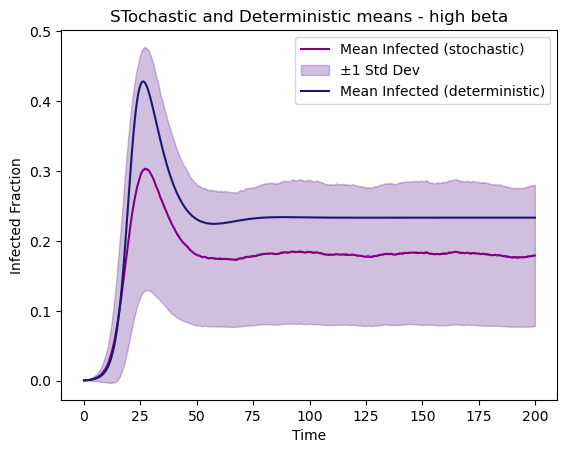

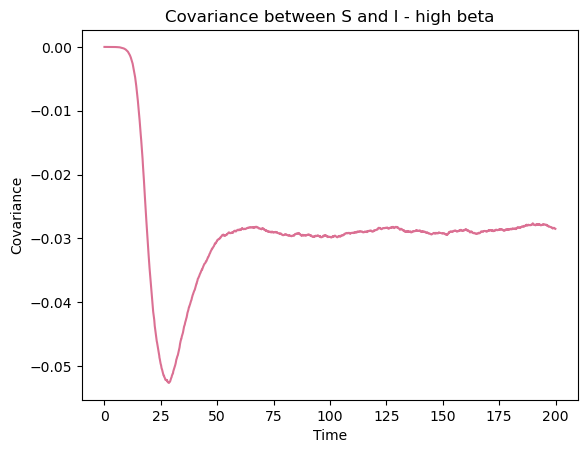

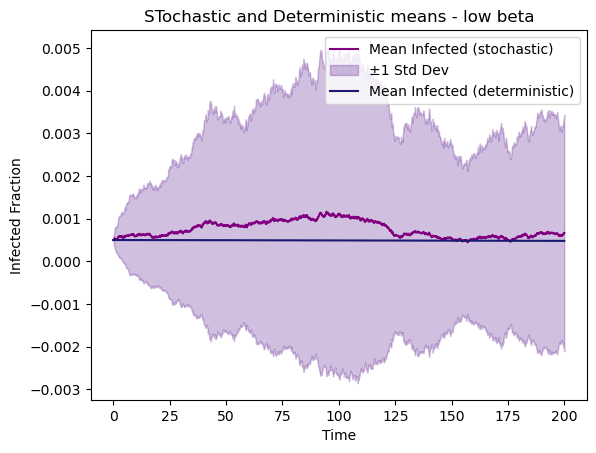

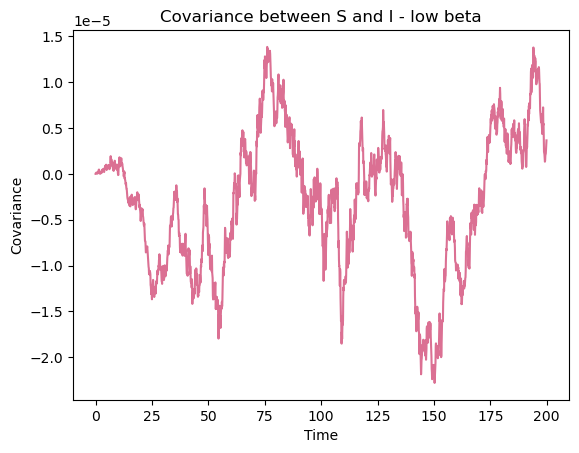

In [136]:
# Exercise 1.2

# Common time grid for comparaisons:
def nice_grid(times, sir, t_grid):
    times = np.array(times)
    vals = np.array(sir)
    index = np.searchsorted(times, t_grid, side='right') - 1 # get value at or before
    index = np.clip(index, 0, len(vals) - 1) 
    return vals[index]

# Get data over multiple runs
def ensemble(n_sims, t, dt, N, beta, gamma, mu):
    t_grid = np.arange(0, t, dt)
    S_ens = np.zeros((n_sims, len(t_grid)))
    I_ens = np.zeros((n_sims, len(t_grid)))
    R_ens = np.zeros((n_sims, len(t_grid)))
    for i in range(n_sims):
        S0, I0, R0 = N - 1, 1, 0
        times, S, I, R = gillespies_sir(t, S0, I0, R0, beta, gamma, mu)
        S_ens[i, :] = (nice_grid(times, np.array(S) / N, t_grid))
        I_ens[i, :] = (nice_grid(times, np.array(I) / N, t_grid))
        R_ens[i, :] = (nice_grid(times, np.array(R) / N, t_grid))
    return t_grid, S_ens, I_ens, R_ens

# Simulation variabiiity
def get_stats(n_sims, t, dt, N, beta, gamma, mu):
    t_grid, S_ens, I_ens, R_ens = ensemble(n_sims, t, dt, N, beta, gamma, mu)

    S_mean = np.mean(S_ens, axis=0)
    I_mean = np.mean(I_ens, axis=0)
    R_mean = np.mean(R_ens, axis=0)
    # std not pure variance, easier to interpret
    S_std = np.std(S_ens, axis=0)
    I_std = np.std(I_ens, axis=0)
    R_std = np.std(R_ens, axis=0)

    cov = ((S_ens - S_mean) * (I_ens - I_mean)).mean(axis=0)

    # get deterministic sir to compare
    S_det, I_det, R_det = integrate_det_sir([N - 1, 1, 0], t_grid, beta, gamma, mu)
    S_det, I_det, R_det = S_det / N, I_det / N, R_det / N # normalise again

    return {'t': t_grid, 
            'S_mean': S_mean, 'I_mean': I_mean, 'R_mean': R_mean,
            'S_std': S_std, 'I_std': I_std, 'R_std': R_std,
            'cov': cov,
            'S_det': S_det, 'I_det': I_det, 'R_det': R_det}
   
# Plot
def plot_stats(stats, title='STochastic and Deterministic means'):
    t = stats['t']
    I_mean, I_std, I_det = stats['I_mean'], stats['I_std'], stats['I_det']

    plt.figure()
    plt.plot(t, I_mean, color='purple', label='Mean Infected (stochastic)')
    plt.fill_between(t, I_mean - I_std, I_mean + I_std, color='indigo', alpha=0.25, label='±1 Std Dev')
    plt.plot(t, I_det, color='midnightblue', label='Mean Infected (deterministic)')
    plt.xlabel('Time')
    plt.ylabel('Infected Fraction')
    plt.legend()
    plt.title(title)
    plt.show()

def plot_cov(stats, title='Covariance between S and I'):
    t = stats['t']
    cov = stats['cov']
    plt.figure()
    plt.plot(t, cov, color='palevioletred')
    plt.xlabel('Time')
    plt.ylabel('Covariance')
    plt.title(title)
    plt.show()

params = [
    {'type': 'baseline', "N": 2000, "beta": 0.3, "gamma": 0.1, "mu": 0.05},
    {'type': 'small N', "N": 200, "beta": 0.3, "gamma": 0.1, "mu": 0.05},
    {'type': 'high beta', "N": 2000, "beta": 0.5, "gamma": 0.1, "mu": 0.05},
    {'type': 'low beta', "N": 2000, "beta": 0.15, "gamma": 0.1, "mu": 0.05}
]

for p in params:
    stats = get_stats(n_sims=100, t=200, dt=0.1, N=p['N'], beta=p['beta'], gamma=p['gamma'], mu=p['mu'])
    plot_stats(stats, title=f'STochastic and Deterministic means - {p["type"]}')
    plot_cov(stats, title=f'Covariance between S and I - {p["type"]}')

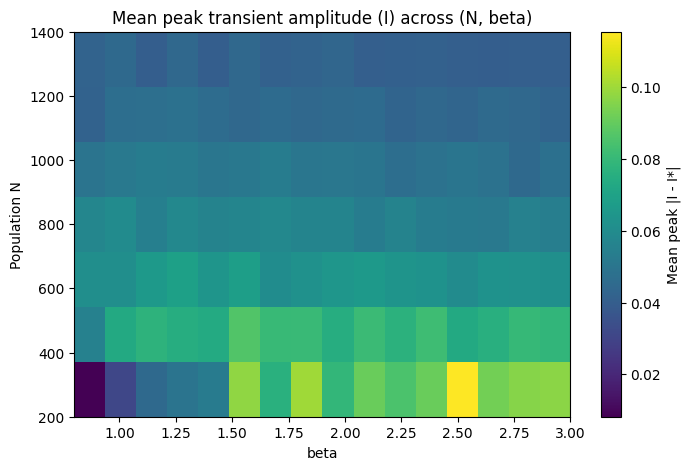

In [22]:
# Exercise 1.3

def endemic_equilibrium(N, beta, gamma, mu):
    R0 = beta / (gamma + mu)
    if R0 <= 1.0:
        S_star = N
        I_star = 0.0
        R_star = 0.0
    else:
        s_star = 1.0 / R0
        i_star = mu * (R0 - 1.0) / beta
        S_star = s_star * N
        I_star = i_star * N
        R_star = N - S_star - I_star
    return S_star, I_star, R_star, R0

gamma = 1/3.0
mu = 0.04
T = 150
beta_factors = np.linspace(0.8, 3.0, 16)
beta_values = beta_factors
N_values = [200, 400, 600, 800, 1000, 1200, 1400]

runs_per_setting = 30

results = []
heat = np.zeros((len(N_values), len(beta_values)))
for iN, N in enumerate(N_values):
    for ib, beta in enumerate(beta_values):
        S_star, I_star, R_star, R0 = endemic_equilibrium(N, beta, gamma, mu)
        peak_amplitudes = []
        for run in range(runs_per_setting):
            S0 = max(0, int(round(S_star)))
            I0 = max(0, int(round(I_star))) or 1
            R0_count = max(0, N - S0 - I0)
            times, S_list, I_list, R_list = gillespies_sir(T, S0, I0, R0_count, beta, gamma, mu)
            times = np.array(times)
            S_list = np.array(S_list)
            I_list = np.array(I_list)
            R_list = np.array(R_list)
            if len(I_list) == 0 or I_list[-1] == 0:
                peak = 0.0
            else:
                peak = max(np.abs((I_list / N) - (I_star / N)))
            peak_amplitudes.append(peak)
        mean_peak = np.mean(peak_amplitudes)
        heat[iN, ib] = mean_peak
        results.append({
            "N": N,
            "beta": beta,
            "R0": round(R0,3),
            "I_star": I_star,
            "mean_peak_I": mean_peak
        })

plt.figure(figsize=(8,5))
plt.imshow(heat, aspect='auto', origin='lower', extent=[beta_values[0], beta_values[-1], N_values[0], N_values[-1]])
plt.colorbar(label='Mean peak |I - I*|')
plt.xlabel('beta')
plt.ylabel('Population N')
plt.title('Mean peak transient amplitude (I) across (N, beta)')
plt.savefig("transientAmplitude.jpg", dpi=300)
plt.show()


In [49]:
gamma = 1/3.0
mu = 0.04
T = 365
beta = 2.5
N = 200
I0 = 1
S0 = N - 1
R0 = 0

S_star, I_star, R_star, R0 = endemic_equilibrium(N, beta, gamma, mu)

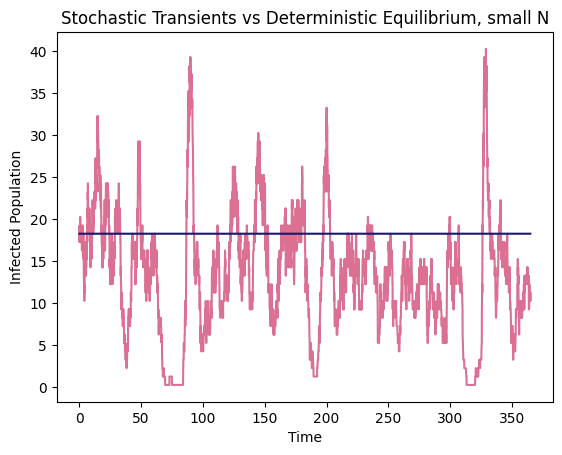

In [50]:
times, sStoTransient, iStoTransient, rStoTrasient = gillespies_sir(T, S_star, I_star, R_star, beta, gamma, mu)

sDetBaseline, iDetBaseline, rDetBaseline = integrate_det_sir([S_star, I_star, R_star], times, beta, gamma, mu)

plt.figure()
plt.plot(times, iStoTransient, color='palevioletred')
plt.plot(times, iDetBaseline, color="midnightblue")
plt.xlabel('Time')
plt.ylabel('Infected Population')
plt.title("Stochastic Transients vs Deterministic Equilibrium, small N")
plt.savefig("transientExample.jpg", dpi=300)
plt.show()


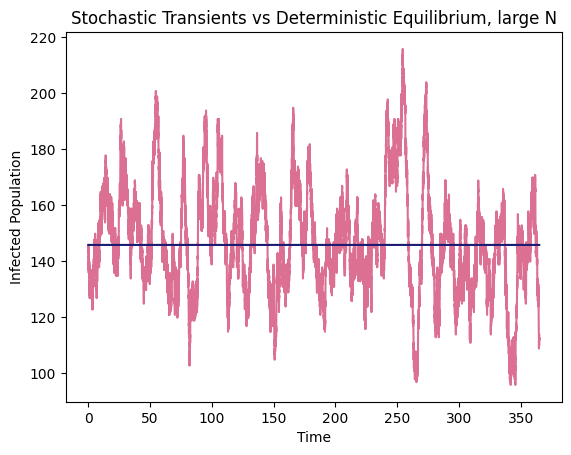

In [51]:
gamma = 1/3.0
mu = 0.04
T = 365
beta = 2.5
N = 1600

S_star, I_star, R_star, R0 = endemic_equilibrium(N, beta, gamma, mu)

times, sStoTransient, iStoTransient, rStoTrasient = gillespies_sir(T, S_star, I_star, R_star, beta, gamma, mu)

sDetBaseline, iDetBaseline, rDetBaseline = integrate_det_sir([S_star, I_star, R_star], times, beta, gamma, mu)

plt.figure()
plt.plot(times, iStoTransient, color='palevioletred')
plt.plot(times, iDetBaseline, color="midnightblue")
plt.xlabel('Time')
plt.ylabel('Infected Population')
plt.title("Stochastic Transients vs Deterministic Equilibrium, large N")
plt.savefig("lesserTransientExample.jpg", dpi=300)
plt.show()

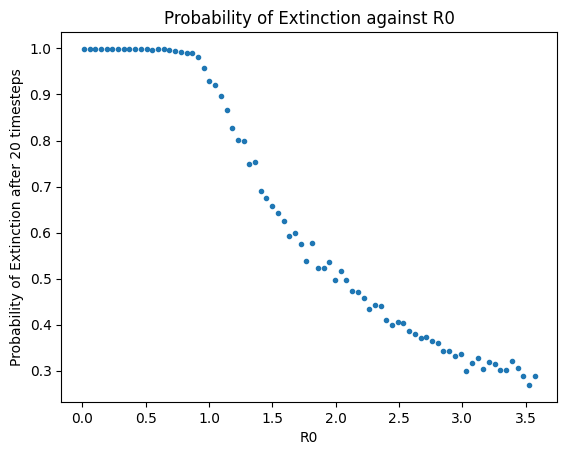

In [ ]:
#Exercise 1.4, this takes a long time to run because of the averaging, took 2 hours on my pc

gamma = 0.8
mu = 0.04
T = 365
n = 10000
I0 = 1
S0 = n - 1
R0 = 0
betas = np.linspace(0.01, 3, 80)
time = 20
r0s = []
extinction_rates = []

for beta in betas:
    extinction_count = 0
    for i in range(1, 1000):
        _, _, I, _ = gillespies_sir(time, S0, I0, R0, beta, gamma, mu)
        if I[-1] == 0:
            extinction_count += 1
    extinction_rates.append(extinction_count / 1000)
    r0s.append(beta / (gamma + mu))

plt.figure()
plt.plot(r0s, extinction_rates, ".")
plt.xlabel("R0")
plt.ylabel(f"Probability of Extinction after {time} timesteps")
plt.title('Probability of Extinction against R0')
plt.savefig("extinctionrate.jpg")
plt.show()


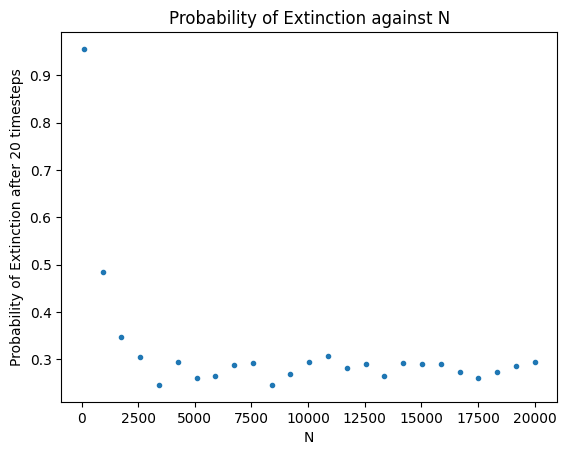

In [47]:
gamma = 0.8
mu = 0.04
T = 365
Ns = np.linspace(100, 20000, 25)
beta = 3 # took a beta with its own probability of extinction to be as low as possible so the effects of the extinction can be more attributed to N size 
time = 20
extinction_rates = []

for N in Ns:
    extinction_count = 0
    I0 = 1
    S0 = N - 1
    R0 = 0
    for i in range(1, 500):
        _, _, I, _ = gillespies_sir(time, S0, I0, R0, beta, gamma, mu)
        if I[-1] == 0:
            extinction_count += 1
    extinction_rates.append(extinction_count / 500)

plt.figure()
plt.plot(Ns, extinction_rates, ".")
plt.xlabel("N")
plt.ylabel(f"Probability of Extinction after {time} timesteps")
plt.title('Probability of Extinction against N')
plt.savefig("extinctionrateNs.jpg")
plt.show()

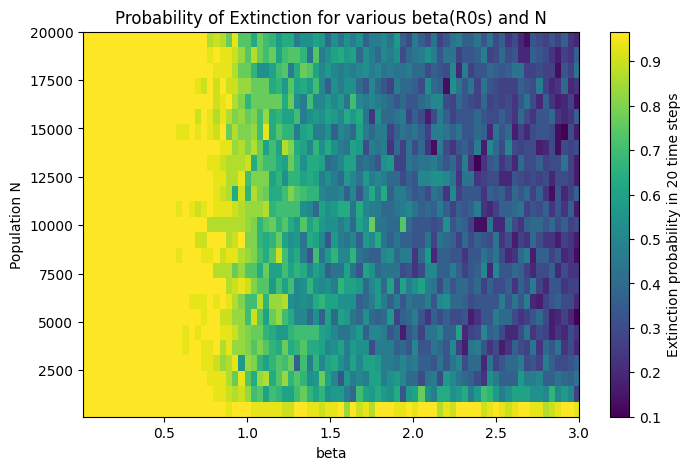

In [46]:
gamma = 0.8
mu = 0.04
T = 20
beta_factors = np.linspace(0.01, 3, 80)
beta_values = beta_factors
N_values = np.linspace(100, 20000, 25)

heat = np.zeros((len(N_values), len(beta_values)))
for iN, N in enumerate(N_values):
    for ib, beta in enumerate(beta_values):
        extinction_count = 0
        I0 = 1
        S0 = N - 1
        R0 = 0
        for i in range(1, 30):
            _, _, I, _ = gillespies_sir(T, S0, I0, R0, beta, gamma, mu)
            if I[-1] == 0:
                extinction_count += 1
        heat[iN, ib] = extinction_count / 30

plt.figure(figsize=(8,5))
plt.imshow(heat, aspect='auto', origin='lower', extent=[beta_values[0], beta_values[-1], N_values[0], N_values[-1]])
plt.colorbar(label=f'Extinction probability in {T} time steps')
plt.xlabel('beta')
plt.ylabel('Population N')
plt.title('Probability of Extinction for various beta(R0s) and N')
plt.savefig("extinctionrateBoth.jpg", dpi=300)
plt.show()

Part2 - Networks
2.1 - up until sociopattern data
'GENERATE NETWORKS OF EQUIVALENT FORM'

In [61]:
# Parameters ('similar characteristics')
N=1000
avg_k = 10

# pretty colors for plots...
colors = {
    'Erdos-Renyi': 'rebeccapurple',
    'Watts-Strogatz': 'darkslategray',
    'Barabasi-Albert': 'hotpink'
}


# Create networks
def make_ws(N, k, seed, p=0.1):
    return nx.watts_strogatz_graph(N, k, p, seed=seed) 

def make_er(N, avg_k, seed):
    p = avg_k / (N - 1)
    return nx.erdos_renyi_graph(N, p, seed=seed)

def make_ba(N, avg_k, seed):
    m = avg_k // 2  
    return nx.barabasi_albert_graph(N, m, seed=seed)



## METRICS AND STATS:

# basic measures:
def get_measures(G, name):
    k = np.array([d for _, d in G.degree()])
    cc = np.fromiter(nx.clustering(G).values(), dtype=float)
    stats= {
        'name': name,
        'nodes' : G.number_of_nodes(),
        'edges' : G.number_of_edges(),
        'avg_degree' : k.mean(),
        'avg_shortest_path': nx.average_shortest_path_length(G) if nx.is_connected(G) else float('inf'),
        'avg_clustering_coeff' : nx.average_clustering(G),
    }
    return stats, k, cc
        

# deg dist
def plot_dd(k_data):
    # PDF hist
    plt.figure()
    for name, k in k_data.items():
        plt.hist(k, bins=range(0, max(k)+2), density=True, label=name, alpha=0.5, color=colors[name]) 
    plt.xlabel('Degree')
    plt.ylabel('P(k)')
    plt.title('Degree Distribution (PDF)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # CCDF plot
    plt.figure()
    for name, k in k_data.items():
        sorted_k = np.sort(k)
        ccdf = 1 - np.arange(1, len(sorted_k) + 1) / len(sorted_k)
        plt.loglog(sorted_k, ccdf, marker='.', linestyle='none', label=name, alpha=0.5, color=colors[name])
    plt.xlabel('Degree')
    plt.ylabel('CCDF')
    plt.title('Degree Distribution (CCDF)')
    plt.legend()
    plt.grid(True)
    plt.show()
    

# clustering dist
def plot_cc(cc_data):
    plt.figure()
    for name, cc in cc_data.items():
        plt.hist(cc, bins=50, density=True, alpha=0.5, label=name, color=colors[name])
    plt.xlabel('Clustering Coefficient')
    plt.ylabel('P(c)')
    plt.title('Clustering Coefficient Distribution')
    plt.legend()
    plt.grid(True)
    plt.show()

# centralities:
def get_centralities(G):
    deg_cent = np.fromiter(nx.degree_centrality(G).values(), dtype=float)
    btw_cent = np.fromiter(nx.betweenness_centrality(G, normalized=True).values(), dtype=float)
    clos_cent = np.fromiter(nx.closeness_centrality(G).values(), dtype=float)
    try:
        ev_cent = np.fromiter(nx.eigenvector_centrality_numpy(G).values(), dtype=float)
    except nx.AmbiguousSolution:
        ev_cent = np.full(G.number_of_nodes(), np.nan)
    return deg_cent, btw_cent, clos_cent, ev_cent


def plot_centralities(cent_data):
    cent_names = {
        'deg': 'Degree Centrality',
        'btw': 'Betweenness Centrality',
        'clos': 'Closeness Centrality',
        'eig': 'Eigenvector Centrality'
    }

    for key, label in cent_names.items():
        plt.figure()
        for name, cents in cent_data.items():
            cent = np.array(cents[key])
            cent = cent[~np.isnan(cent)]  
            plt.hist(cent, bins=50, density=True, alpha=0.5, label=name, color=colors[name])
        plt.xlabel(label)
        plt.ylabel('P(c)')
        plt.title(f'{label} Distribution')
        plt.legend()
        plt.grid(True)
        plt.show()

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)



Network measures (averaged):


,nodes,edges,avg_degree,avg_shortest_path,avg_clustering_coeff
0,1000.0,4997.23,9.99446,inf,0.009938
1,1000.0,5000.00,10.00000,4.441046,0.491534
2,1000.0,4975.00,9.95000,2.983357,0.039742


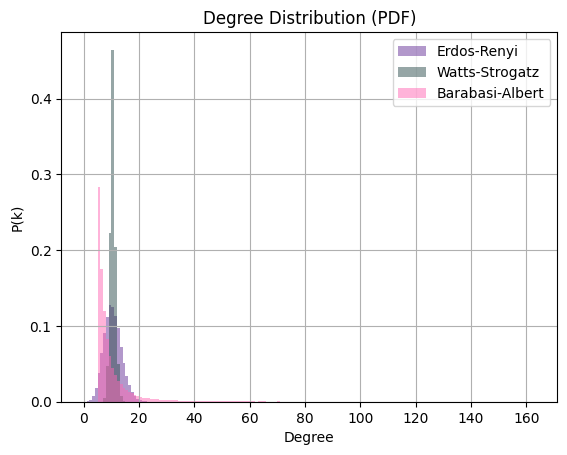

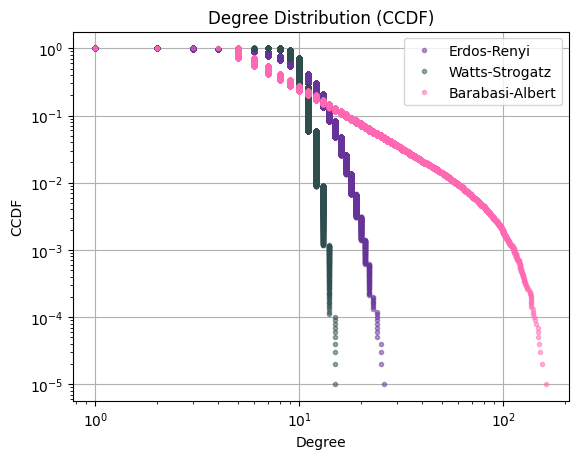

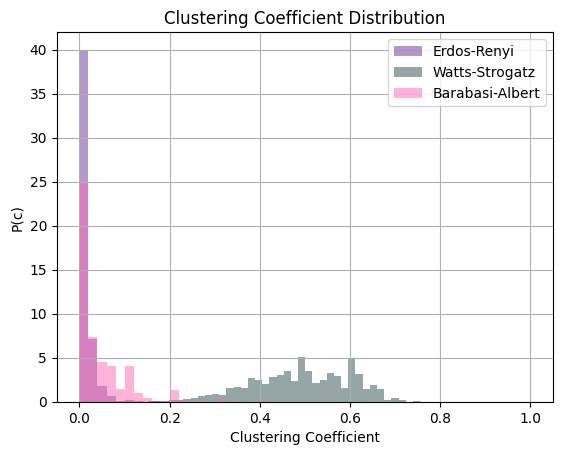

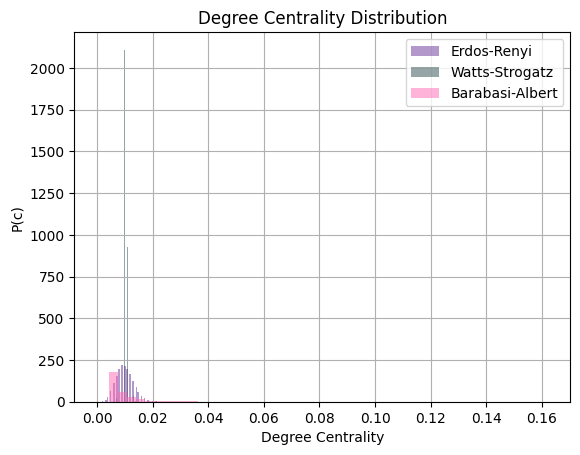

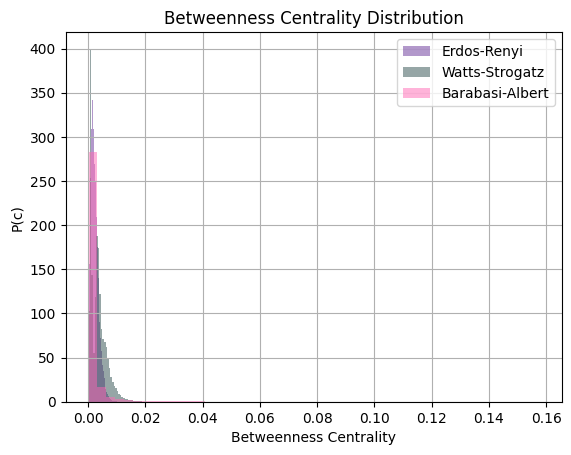

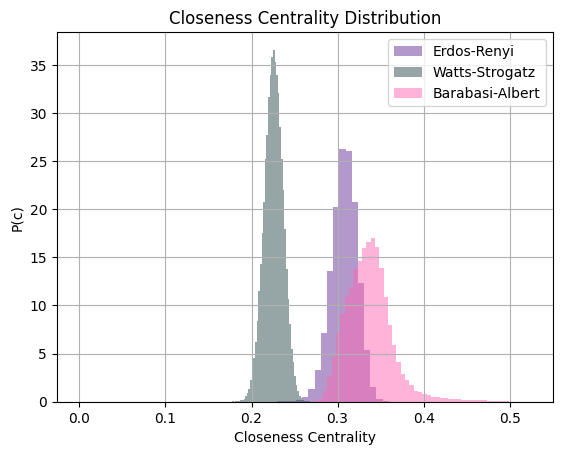

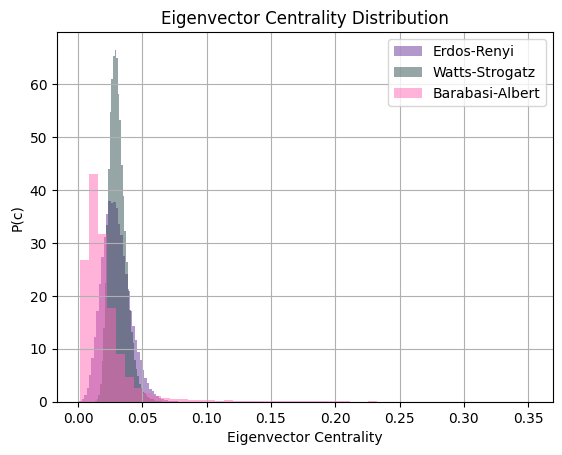

In [62]:
## Basic comparisons:
networks = {
    'Erdos-Renyi': make_er,
    'Watts-Strogatz': make_ws,
    'Barabasi-Albert': make_ba
}
sums = []
k_data = {}
cc_data = {}
cent_data = {}
seedy = range(1, 101)

for name, make_func in networks.items():
    all_stats = []
    all_k = []
    all_cc = []
    all_cents = {'deg': [], 'btw': [], 'clos': [], 'eig': []}

    for s in seedy:
        if name == 'Watts-Strogatz':
            G = make_func(N, avg_k, s, p=0.1)
        else:
            G = make_func(N, avg_k, s)

        s_stats, k, cc = get_measures(G, name)
        all_stats.append(s_stats)
        all_k.extend(k)
        all_cc.extend(cc)

        deg_cent, btw_cent, clos_cent, ev_cent = get_centralities(G)
        all_cents['deg'].extend(deg_cent)
        all_cents['btw'].extend(btw_cent)
        all_cents['clos'].extend(clos_cent)
        all_cents['eig'].extend(ev_cent)

    # average 
    stats_df = pd.DataFrame(all_stats)
    mean_stats = stats_df.mean(numeric_only=True)
    std_stats = stats_df.std(numeric_only=True)

    # for plots
    sums.append(mean_stats)
    k_data[name] = np.array(all_k)
    cc_data[name] = np.array(all_cc)
    cent_data[name] = all_cents

measures_df = pd.DataFrame(sums)
print("\nNetwork measures (averaged):")
display(measures_df)

plot_dd(k_data)
plot_cc(cc_data)
plot_centralities(cent_data)

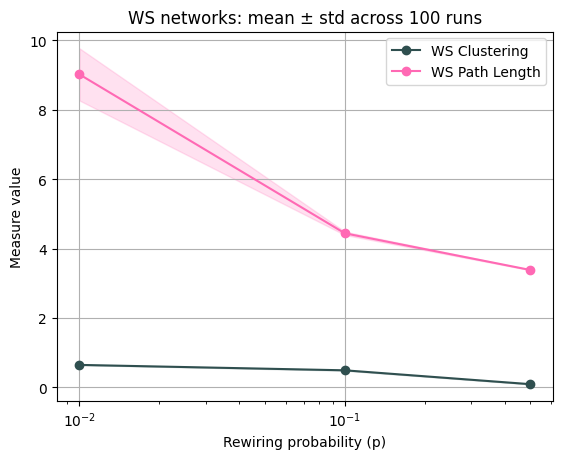

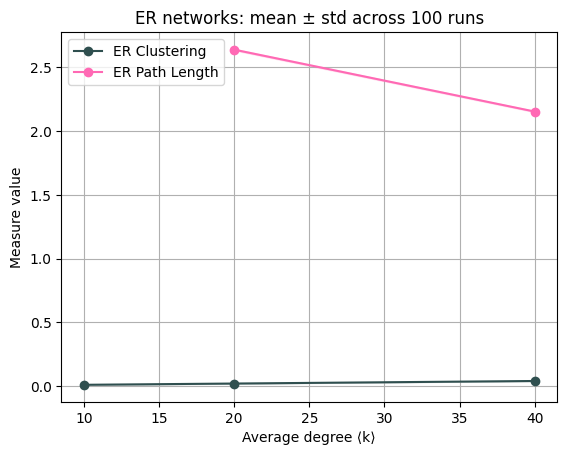

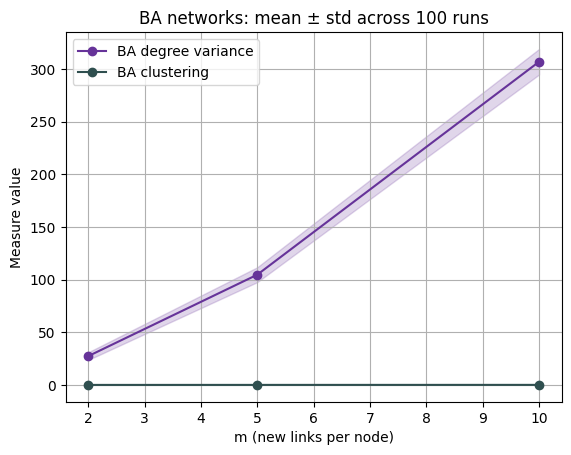

In [63]:
## Varying params:
# not comparing all measures this time, just specific ones for diff topologies
seed = range(42, 143)

def get_specifics(G):
    k = np.array([d for _, d in G.degree()])
    return {
        'avg_degree': k.mean(),
        'degree_var': k.var(),
        'C': nx.average_clustering(G),
        'L': nx.average_shortest_path_length(G) if nx.is_connected(G) else float('inf')
    }

def vary_ws(N, k, p_values, seeds):
    data = []
    for p in p_values:
        for s in seeds:
            G = make_ws(N, k, s, p)
            m = get_specifics(G)
            m.update({'p': p, 'seed': s})
            data.append(m)
    return pd.DataFrame(data)

def vary_er(N, k_values, seeds):
    data = []
    for k in k_values:
        for s in seeds:
            G = make_er(N, k, s)
            m = get_specifics(G)
            m.update({'avg_k': k, 'seed': s})
            data.append(m)
    return pd.DataFrame(data)

def vary_ba(N, m_values, seeds):
    data = []
    for m in m_values:
        for s in seeds:
            G = nx.barabasi_albert_graph(N, m, seed=s)
            mtr = get_specifics(G)
            mtr.update({'m': m, 'seed': s})
            data.append(mtr)
    return pd.DataFrame(data)

ws_df = vary_ws(N, avg_k, [0.01, 0.1, 0.5], seed)
er_df = vary_er(N, [ 10, 20, 40], seed)
ba_df = vary_ba(N, [2, 5, 10], seed)

# Plot mean +std
def plot_ens(df, xcol, ycol, label, color):
    grouped = df.groupby(xcol)[ycol]
    x = grouped.mean().index
    x = np.sort(x)
    y_mean = grouped.mean().values
    y_std = grouped.std().values
    plt.plot(x, y_mean, 'o-', color=color, label=label)
    plt.fill_between(x, y_mean - y_std, y_mean + y_std, color=color, alpha=0.2)

plt.figure()
plot_ens(ws_df, 'p', 'C', 'WS Clustering', 'darkslategray')
plot_ens(ws_df, 'p', 'L', 'WS Path Length', 'hotpink')
plt.xscale('log')
plt.xlabel('Rewiring probability (p)')
plt.ylabel('Measure value')
plt.title('WS networks: mean ± std across 100 runs')
plt.legend(); plt.grid(True); plt.show()

plt.figure()
plot_ens(er_df, 'avg_k', 'C', 'ER Clustering', 'darkslategray')
plot_ens(er_df, 'avg_k', 'L', 'ER Path Length', 'hotpink')
plt.xlabel('Average degree ⟨k⟩')
plt.ylabel('Measure value')
plt.title('ER networks: mean ± std across 100 runs')
plt.legend(); plt.grid(True); plt.show()

plt.figure()
plot_ens(ba_df, 'm', 'degree_var', 'BA degree variance', 'rebeccapurple')
plot_ens(ba_df, 'm', 'C', 'BA clustering', 'darkslategray')
plt.xlabel('m (new links per node)')
plt.ylabel('Measure value')
plt.title('BA networks: mean ± std across 100 runs')
plt.legend(); plt.grid(True); plt.show()

In [64]:
# implementations and stats

def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)


def initial_nodes(G, k, strategy='rand'):
    if strategy == 'rand':
        return np.random.choice(G.nodes(), k, replace=False).tolist()
    elif strategy == 'high_deg':
        degree_dict = dict(G.degree())
        sorted_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)
        return sorted_nodes[:k]
    elif strategy == 'eigen':
        ev_centrality = nx.eigenvector_centrality_numpy(G)
        sorted_nodes = sorted(ev_centrality, key=ev_centrality.get, reverse=True)
        return sorted_nodes[:k]
    elif strategy == 'cluster':
        node = np.random.choice(G.nodes())
        neighbors = list(G.neighbors(node))
        choice = [node] + neighbors[:max(0, k - 1)]
        if len(choice) < k:
            oth = list(set(G.nodes()) - set(choice))
            choice += list(np.random.choice(oth, k - len(choice), replace=False))
        return choice
    else:
        raise ValueError("??")

    


# Run and get results:
def run_single_sir(G, beta, gamma, infected_nodes, max_iter, seed):
    set_all_seeds(seed) # keeping same

    # build
    model = SIR(G)
    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter('gamma', gamma)
    config.add_model_initial_configuration("Infected", infected_nodes)
    model.set_initial_status(config)

    # get reults
    iters = model.iteration_bunch(max_iter)
    node_counts = [i.get('node_count', {0: 0, 1: 0, 2: 0}) for i in iters]
    node_count = np.array([[d.get(0, 0), d.get(1, 0), d.get(2, 0)] for d in node_counts])

    N = G.number_of_nodes()
    t = np.arange(len(node_count))
    S, I, R = node_count[:, 0] / N, node_count[:, 1] / N, node_count[:, 2] / N

    series = pd.DataFrame({'t': t, 'S': S, 'I': I, 'R': R})
    return iters, series


# Ensemble and stats:

# helper
def stats_series(df):
    return{
    'peak_I': df['I'].max(),
    'time_to_peak': df.loc[df['I'].idxmax(), 't'],
    'final_frac_R': df['R'].iloc[-1]
    }

# Run ensemble
def ensemble_nx(n_sims, G, beta, gamma, k, strategy, max_iter, seed):
    series = []
    stats_a =[]
    for i in range(n_sims):
        init_n = initial_nodes(G, k, strategy=strategy)
    
        _, s = run_single_sir(G, beta, gamma, init_n, max_iter, seed+i)
        series.append(s)
        stats_a.append(stats_series(s))
    
    # matrices
    t = series[0]['t'].values
    S_ens = np.vstack([s['S'].values for s in series])
    I_ens = np.vstack([s['I'].values for s in series])
    R_ens = np.vstack([s['R'].values for s in series])

    stats = dict(
        t=t,
        S_mean=S_ens.mean(0), S_std=S_ens.std(0),
        I_mean=I_ens.mean(0), I_std=I_ens.std(0),
        R_mean=R_ens.mean(0), R_std=R_ens.std(0)
    )

    return series, stats, pd.DataFrame(stats_a)


def plot_I_stats(stats, color='hotpink', alpha = 0.5, title='Infected Fraction over Time'):
    t = stats['t']
    I_mean = stats['I_mean']
    I_std = stats['I_std']

    plt.figure()
    plt.plot(t, I_mean, color=color, alpha=alpha, label='Mean Infected')
    plt.fill_between(t, I_mean - I_std, I_mean + I_std, color=color, alpha=0.25, label='std')
    plt.xlabel('Time')
    plt.ylabel('Infected Fraction')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

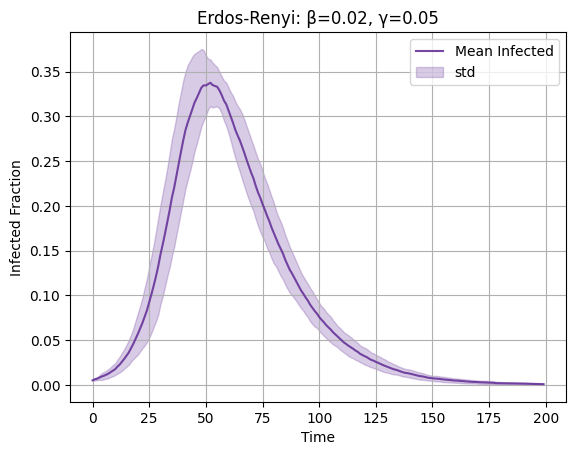

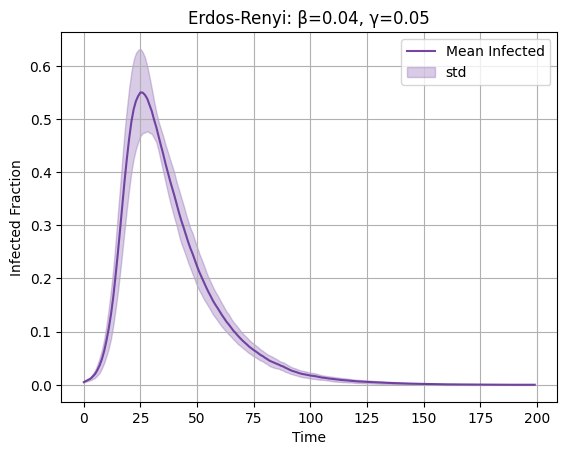

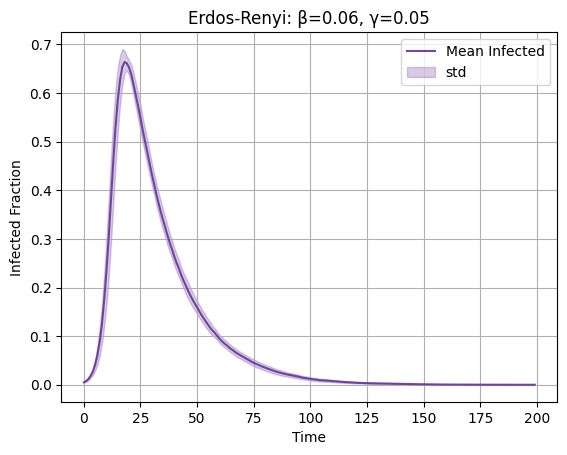

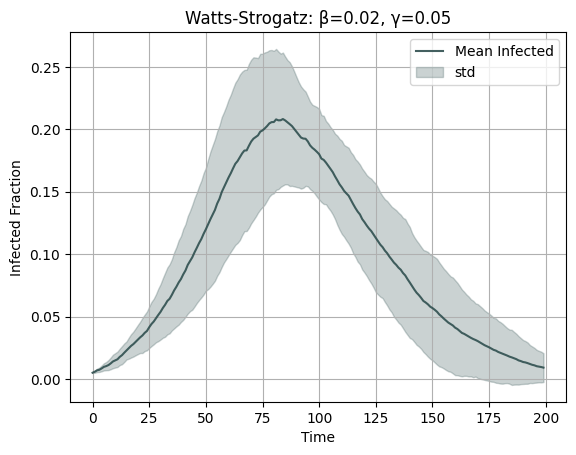

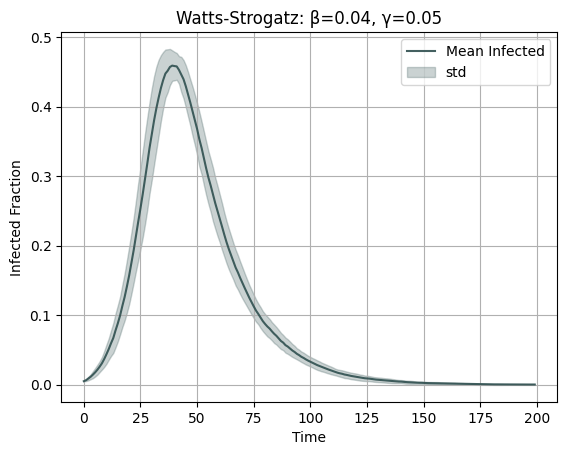

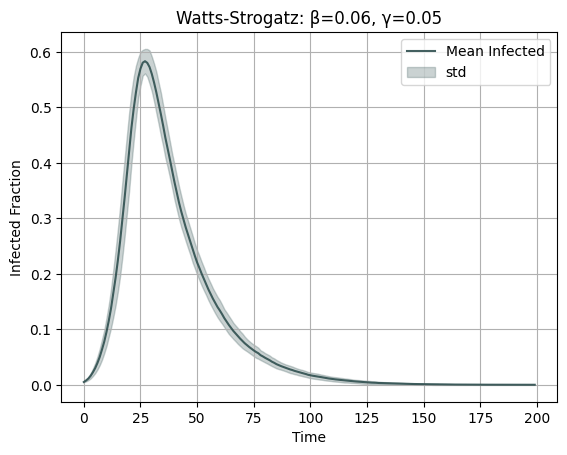

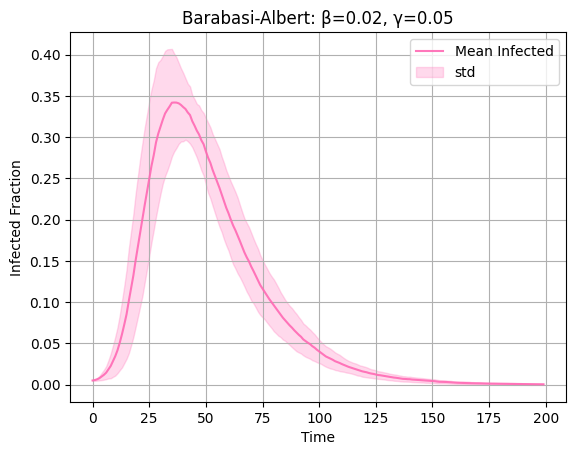

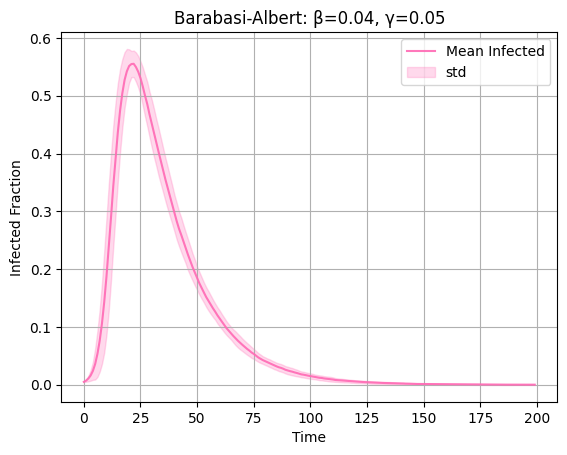

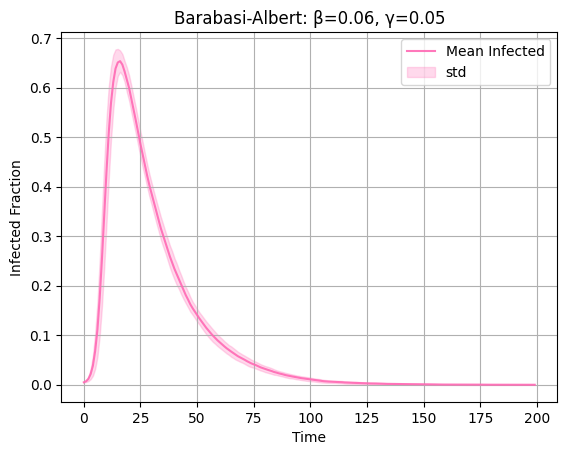

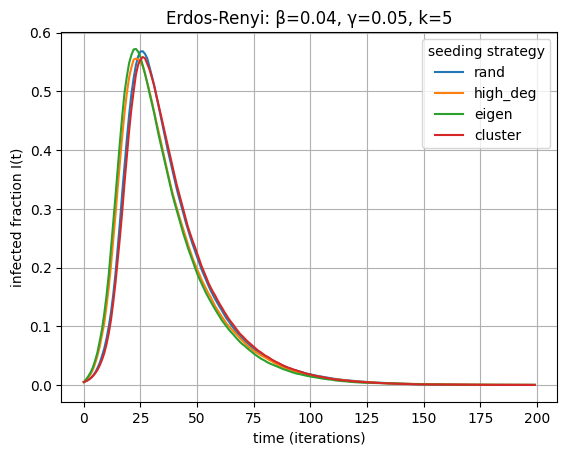

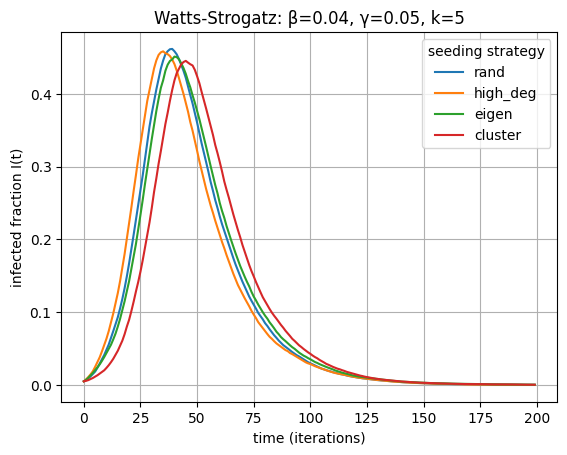

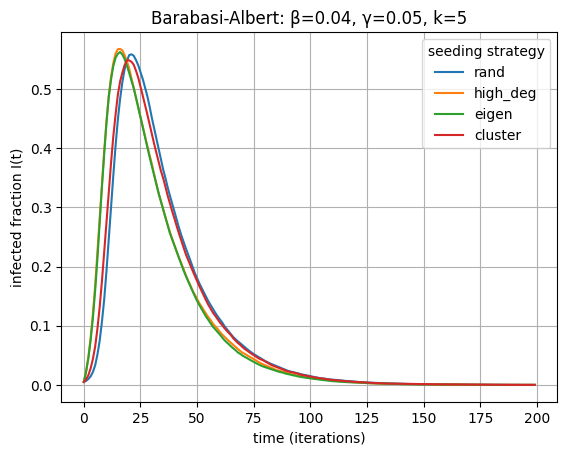

,network,beta,strategy,peak_I_mean,t_peak_mean,final_R_mean
0,Erdos-Renyi,0.02,rand,0.357100,51.000000,0.927000
1,Erdos-Renyi,0.04,rand,0.573433,25.633333,0.986800
2,Erdos-Renyi,0.06,rand,0.674200,18.066667,0.994733
3,Watts-Strogatz,0.02,rand,0.243900,87.566667,0.925867
4,Watts-Strogatz,0.04,rand,0.475767,39.500000,0.997033
5,Watts-Strogatz,0.06,rand,0.594867,26.766667,0.999700
6,Barabasi-Albert,0.02,rand,0.372233,36.100000,0.885067
7,Barabasi-Albert,0.04,rand,0.570600,21.033333,0.978633
8,Barabasi-Albert,0.06,rand,0.663900,15.166667,0.994400
9,Erdos-Renyi,0.04,rand,0.570467,26.200000,0.985867


In [65]:
# params

betas = [0.02, 0.04, 0.06]
gamma = 0.05
max_iter = 200
n_runs = 30
strats = ['rand', 'high_deg', 'eigen', 'cluster']
k_init = 5 # same as experiment
base = 42


networks = {
    'Erdos-Renyi': make_er(N=1000, avg_k=10, seed=1),
    'Watts-Strogatz': make_ws(N=1000, k=10, seed=1, p=0.1),
    'Barabasi-Albert': make_ba(N=1000, avg_k=10, seed=1)
}

strat_colors = {
    'rand': 'darksalmon',
    'high_deg': 'darkkhaki',
    'eigen': 'cadetblue',
    'cluster': 'orchid'
}

results = []

# reduced version to not have so many plots
for name, G in networks.items():
    for beta in betas:
        series, stats, summary = ensemble_nx(
            n_sims=n_runs,
            G=G,
            beta=beta,
            gamma=gamma,
            k=k_init,
            strategy='rand',
            max_iter=max_iter,
            seed=base
        )
        results.append({
            'network': name,
            'beta': beta,
            'strategy': 'rand',
            'peak_I_mean': summary['peak_I'].mean(),
            't_peak_mean': summary['time_to_peak'].mean(),
            'final_R_mean': summary['final_frac_R'].mean()
        })
        plot_I_stats(stats, title=f"{name}: β={beta}, γ={gamma}", color=colors[name], alpha=0.9)

# compare initialisations separate
fixed_beta = 0.04
for name, G in networks.items():
    for strat in strats:
        series, stats, summary = ensemble_nx(
            n_sims=n_runs,
            G=G,
            beta=fixed_beta,
            gamma=gamma,
            k=k_init,
            strategy=strat,
            max_iter=max_iter,
            seed=base
        )
        results.append({
            'network': name,
            'beta': fixed_beta,
            'strategy': strat,
            'peak_I_mean': summary['peak_I'].mean(),
            't_peak_mean': summary['time_to_peak'].mean(),
            'final_R_mean': summary['final_frac_R'].mean()
        })
    plt.figure()
    for strat in strats:
        s = [r for r in results if r['network']==name and r['strategy']==strat and r['beta']==fixed_beta]
        if not s:
            continue
        stats = ensemble_nx(
            n_sims=n_runs,
            G=G,
            beta=fixed_beta,
            gamma=gamma,
            k=k_init,
            strategy=strat,
            max_iter=max_iter,
            seed=base
        )[1]
        plt.plot(stats['t'], stats['I_mean'], label=strat)
    plt.xlabel("time (iterations)")
    plt.ylabel("infected fraction I(t)")
    plt.title(f"{name}: β={fixed_beta}, γ={gamma}, k={k_init}")
    plt.legend(title="seeding strategy")
    plt.grid(True)
    plt.show()
    
# combine
results_df = pd.DataFrame(results)
display(results_df)

In [66]:
# read in the data
df = pd.read_csv("transmission_network.csv", sep=";")
A = df.drop(columns=["Unnamed: 0"]).to_numpy(dtype=float)
A[A > 0] = 1 # hope i converted correctly??
G = nx.from_numpy_array(A)

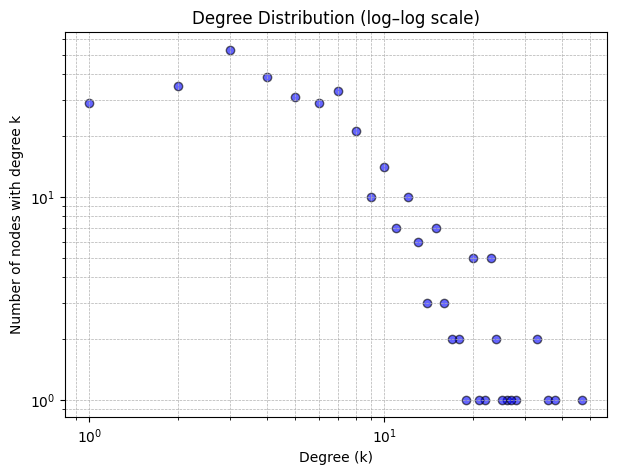

In [ ]:
degrees = [deg for _, deg in G.degree()]

degree_count = {}
for d in degrees:
    degree_count[d] = degree_count.get(d, 0) + 1

x = list(degree_count.keys())
y = list(degree_count.values())

plt.figure(figsize=(7, 5))
plt.scatter(x, y, color='blue', alpha=0.6, edgecolors='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree (k)")
plt.ylabel("Number of nodes with degree k")
plt.title("Degree Distribution (log–log scale)")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()


Calculating best minimal value for power law fit
Alpha (exponent): 3.129
Xmin (lower bound of fit): 7.0
Power-law vs exponential: R=8.529, p=0.067


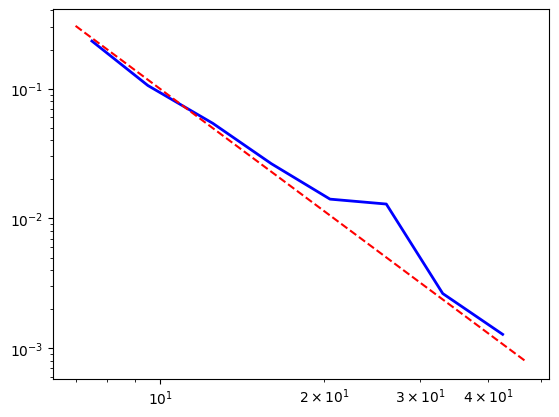

In [ ]:
degrees = [d for _, d in G.degree() if d > 0]

fit = powerlaw.Fit(degrees)

R, p = fit.distribution_compare('power_law', 'exponential')
print(f"Power-law vs exponential: R={R:.3f}, p={p:.3f}")

fig = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='r', linestyle='--', ax=fig)
plt.show()


In [ ]:
def run_simulation(G, beta=0.05, gamma=0.1,
                   vacc_budget=5, test_budget=10,
                   test_accuracy=1.0, strategy="dynamic",
                   max_steps=50):
    """Run one simulation of disease spread and vaccination strategy."""

    nodes = list(G.nodes())
    state = {n: "S" for n in nodes}
    vaccinated = []

    # Start with 5 random infected nodes
    infected = random.sample(nodes, 5)
    for n in infected:
        state[n] = "I"

    for t in range(max_steps):
        new_state = state.copy()
        # --- Testing phase ---
        test_candidates = select_nodes_to_test(G, test_budget, vaccinated)
        observed_status = {}

        for n in test_candidates:
            if random.random() < test_accuracy:
                test_result = new_state[n]
            else:
                test_result = random.choice([s for s in ["S", "I", "R"] if s != new_state[n]])
            observed_status[n] = test_result

        # --- Vaccination phase ---
        vaccinatees = select_nodes_to_vaccinate(G, observed_status, vacc_budget, strategy, vaccinated)
        for candidate in vaccinatees:
            vaccinated.append(candidate)
        for n in vaccinatees:
            new_state[n] = "R"

        state = new_state

        # --- Infection spread ---
        for n in nodes:
            if state[n] == "I":
                for nb in G.neighbors(n):
                    if state[nb] == "S" and random.random() < beta:
                        new_state[nb] = "I"
                # Recovery
                if random.random() < gamma:
                    new_state[n] = "R"

        state = new_state

        if not any(s == "I" for s in state.values()):
            break
    total_removed = sum(s == "R" for s in state.values())
    total_susceptibles = sum(s == "S" for s in state.values())
    total_infected = sum(s == "I" for s in state.values())

    return {
        "final_removed": total_removed,
        "final_infected": total_infected,
        "final_susceptible": total_susceptibles,
        "steps": t + 1
    }

def select_nodes_to_test(G, test_budget, vaccinated):
    possibleTests = [n for n in G.nodes if n not in vaccinated]
    candidates = sorted(possibleTests, key=lambda n: G.degree(n), reverse=True)
    return candidates[:test_budget]

def select_nodes_to_vaccinate(G, observed_status, vacc_budget, strategy, vaccinated):
    """
    Returns a list of up to vacc_budget nodes to vaccinate this timestep.
    - strategy == "random": random unvaccinated nodes
    - strategy == "dynamic": prefer infected nodes (if available), else high-degree neighbors,
      then tested susceptibles, then top-degree remaining unvaccinated nodes to fill budget.
    """
    if strategy == "random":
        available = [n for n in G.nodes() if n not in vaccinated]
        candidates = random.sample(available, min(vacc_budget, len(available)))
        return candidates

    candidates = []

    # Step 1: handle tested nodes (prefer infected nodes themselves)
    for n, status in observed_status.items():
        if status == "I":
            # Prefer vaccinating the infected node itself, if available
            if n not in vaccinated and n not in candidates:
                candidates.append(n)
            else:
                # If the infected node can't be vaccinated, choose the highest-degree neighbor
                nbs = [nb for nb in G.neighbors(n) if nb not in vaccinated and nb not in candidates]
                if nbs:
                    nbs = sorted(nbs, key=lambda nb: G.degree(nb), reverse=True)
                    candidates.append(nbs[0])
        elif status == "S":
            if n not in vaccinated and n not in candidates:
                candidates.append(n)

    # Step 2: if we still have budget left, fill with top-degree unvaccinated nodes
    if len(candidates) < vacc_budget:
        unused = vacc_budget - len(candidates)
        remaining = [n for n in G.nodes() if n not in vaccinated and n not in candidates]
        remaining = sorted(remaining, key=lambda n: G.degree(n), reverse=True)
        candidates.extend(remaining[:unused])
    return candidates[:vacc_budget]



   strategy  vacc_budget  test_accuracy  mean_infected  std_infected  \
0   dynamic            1           0.50      74.543333      7.238516   
1   dynamic            1           0.75      73.956667      8.000091   
2   dynamic            1           1.00      72.343333      7.909530   
3   dynamic            3           0.50      47.190000      6.291197   
4   dynamic            3           0.75      46.253333      6.181953   
5   dynamic            3           1.00      45.656667      5.825109   
6   dynamic            5           0.50      18.960000      4.044700   
7   dynamic            5           0.75      18.213333      3.907949   
8   dynamic            5           1.00      17.706667      3.991708   
9   dynamic           10           0.50       0.000000      0.000000   
10  dynamic           10           0.75       0.000000      0.000000   
11  dynamic           10           1.00       0.000000      0.000000   
12   random            1           0.50      75.690000      7.60

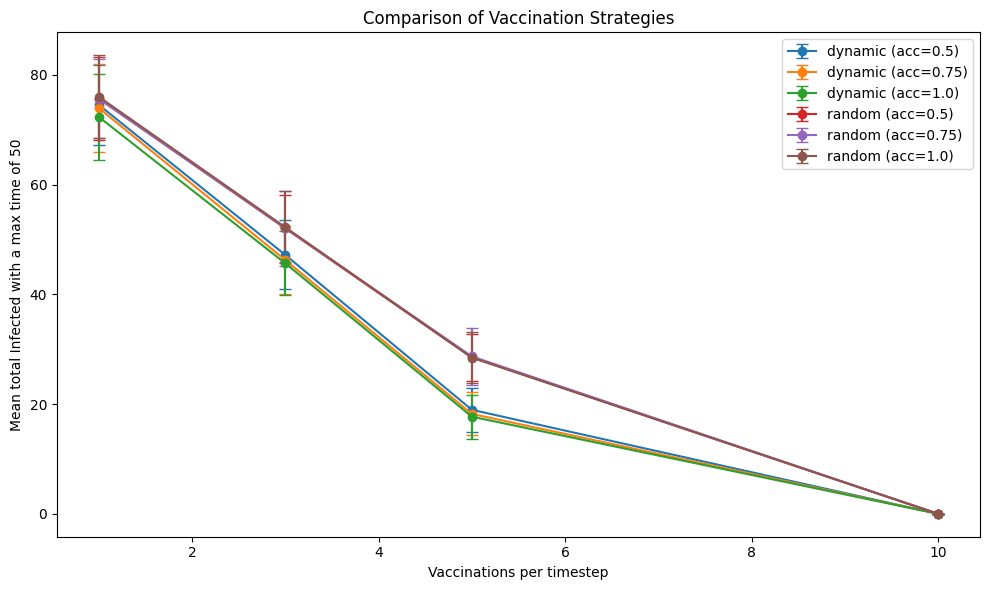

In [ ]:
def run_experiments(G, repetitions=100):
    results = []
    vaccination_budgets = [1, 3, 5, 10]
    test_accuracies = [0.5, 0.75, 1.0]
    strategies = ["dynamic", "random"]

    for strategy in strategies:
        for vacc_budget in vaccination_budgets:
            for accuracy in test_accuracies:
                for rep in range(repetitions):   
                    sim = run_simulation(
                        G,
                        beta=0.15,
                        gamma=0.03,
                        vacc_budget=vacc_budget,
                        test_budget=10,
                        test_accuracy=accuracy,
                        strategy=strategy,
                        max_steps=50,
                    )
                    results.append({
                        "strategy": strategy,
                        "vacc_budget": vacc_budget,
                        "test_accuracy": accuracy,
                        "rep": rep,
                        "final_infected": sim["final_infected"],
                        "final_susceptible": sim["final_susceptible"],
                        "final_removed": sim["final_removed"],
                        "steps": sim["steps"]
                    })
    return pd.DataFrame(results)


def summarize_results(df):
    summary = (
        df.groupby(["strategy", "vacc_budget", "test_accuracy"])
        .agg(mean_infected=("final_infected", "mean"),
             std_infected=("final_infected", "std"),
             mean_steps=("steps", "mean"))
        .reset_index()
    )
    return summary


def plot_results(summary):
    fig, ax = plt.subplots(figsize=(10, 6))
    for strategy in summary["strategy"].unique():
        subset = summary[summary["strategy"] == strategy]
        for acc in [0.5, 0.75, 1.0]:
            acc_subset = subset[subset["test_accuracy"] == acc]
            ax.errorbar(acc_subset["vacc_budget"], acc_subset["mean_infected"],
                        yerr=acc_subset["std_infected"],
                        label=f"{strategy} (acc={acc})",
                        marker="o", capsize=4)
    ax.set_xlabel("Vaccinations per timestep")
    ax.set_ylabel("Mean total Infected with a max time of 50")
    ax.legend()
    ax.set_title("Comparison of Vaccination Strategies")
    plt.tight_layout()
    plt.savefig("infected.jpg", dpi=300)
    plt.show()


df = run_experiments(G, repetitions=300)

summary = summarize_results(df)
print(summary)

plot_results(summary)


   strategy  vacc_budget  test_accuracy  mean_removed  std_removed  mean_steps
0   dynamic            1           0.50    264.513333     7.711987   50.000000
1   dynamic            1           0.75    265.126667     8.638637   50.000000
2   dynamic            1           1.00    266.180000     7.998804   50.000000
3   dynamic            3           0.50    274.320000     8.424221   50.000000
4   dynamic            3           0.75    273.936667     8.913519   50.000000
5   dynamic            3           1.00    274.333333     8.131582   50.000000
6   dynamic            5           0.50    296.113333     6.434685   50.000000
7   dynamic            5           0.75    296.506667     6.575771   50.000000
8   dynamic            5           1.00    296.410000     6.897862   50.000000
9   dynamic           10           0.50    353.470000    11.882469   35.266667
10  dynamic           10           0.75    353.536667    12.020968   35.280000
11  dynamic           10           1.00    351.66333

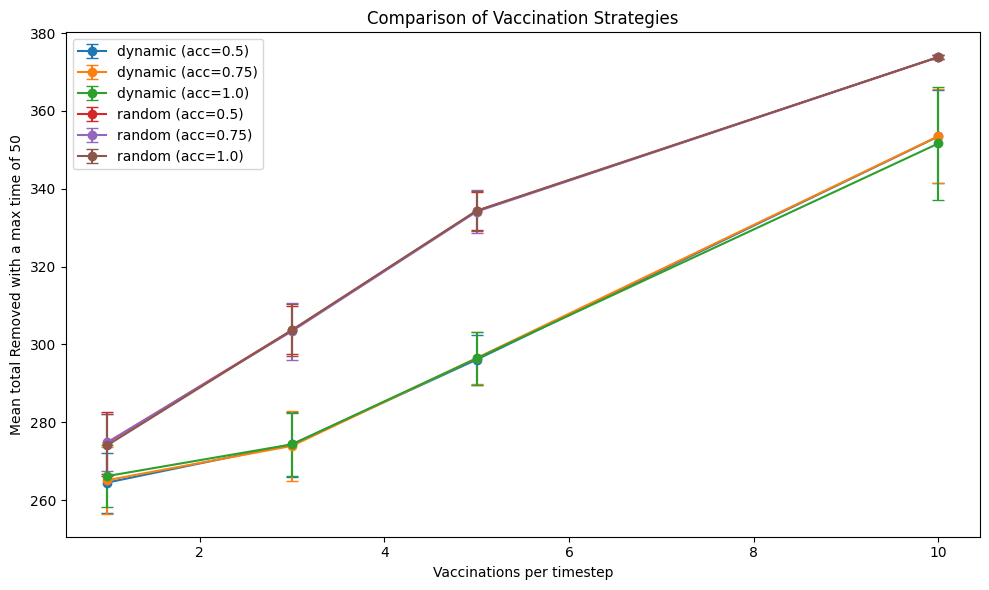

In [202]:
#yes I know this is stupid but i'm tired boss I'm just copy pasting
def summarize_results(df):
    summary = (
        df.groupby(["strategy", "vacc_budget", "test_accuracy"])
        .agg(mean_removed=("final_removed", "mean"),
             std_removed=("final_removed", "std"),
             mean_steps=("steps", "mean"))
        .reset_index()
    )
    return summary

def plot_results(summary):
    fig, ax = plt.subplots(figsize=(10, 6))
    for strategy in summary["strategy"].unique():
        subset = summary[summary["strategy"] == strategy]
        for acc in [0.5, 0.75, 1.0]:
            acc_subset = subset[subset["test_accuracy"] == acc]
            ax.errorbar(acc_subset["vacc_budget"], acc_subset["mean_removed"],
                        yerr=acc_subset["std_removed"],
                        label=f"{strategy} (acc={acc})",
                        marker="o", capsize=4)
    ax.set_xlabel("Vaccinations per timestep")
    ax.set_ylabel("Mean total Removed with a max time of 50")
    ax.legend()
    ax.set_title("Comparison of Vaccination Strategies")
    plt.tight_layout()
    plt.savefig("removed.jpg", dpi=300)
    plt.show()

summary = summarize_results(df)
print(summary)

plot_results(summary)

   strategy  vacc_budget  test_accuracy   mean_sus    std_sus  mean_steps
0   dynamic            1           0.50  34.943333   4.005029   50.000000
1   dynamic            1           0.75  34.916667   4.212943   50.000000
2   dynamic            1           1.00  35.476667   4.129524   50.000000
3   dynamic            3           0.50  52.490000   6.455655   50.000000
4   dynamic            3           0.75  53.810000   7.449309   50.000000
5   dynamic            3           1.00  54.010000   6.600134   50.000000
6   dynamic            5           0.50  58.926667   6.657002   50.000000
7   dynamic            5           0.75  59.280000   6.714055   50.000000
8   dynamic            5           1.00  59.883333   7.790509   50.000000
9   dynamic           10           0.50  20.530000  11.882469   35.266667
10  dynamic           10           0.75  20.463333  12.020968   35.280000
11  dynamic           10           1.00  22.336667  14.561483   35.090000
12   random            1           0.5

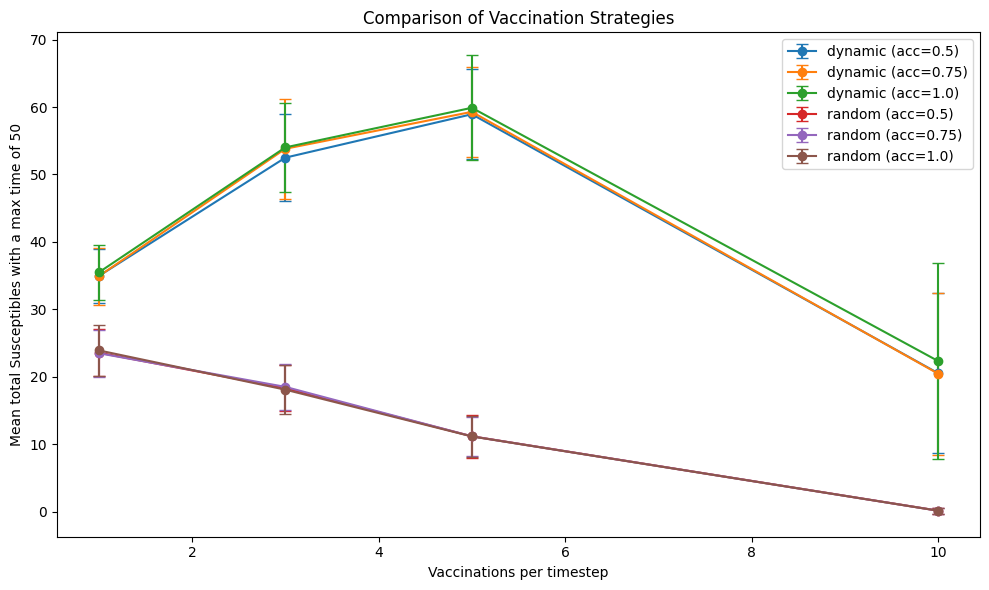

In [203]:
def summarize_results(df):
    summary = (
        df.groupby(["strategy", "vacc_budget", "test_accuracy"])
        .agg(mean_sus=("final_susceptible", "mean"),
             std_sus=("final_susceptible", "std"),
             mean_steps=("steps", "mean"))
        .reset_index()
    )
    return summary

def plot_results(summary):
    fig, ax = plt.subplots(figsize=(10, 6))
    for strategy in summary["strategy"].unique():
        subset = summary[summary["strategy"] == strategy]
        for acc in [0.5, 0.75, 1.0]:
            acc_subset = subset[subset["test_accuracy"] == acc]
            ax.errorbar(acc_subset["vacc_budget"], acc_subset["mean_sus"],
                        yerr=acc_subset["std_sus"],
                        label=f"{strategy} (acc={acc})",
                        marker="o", capsize=4)
    ax.set_xlabel("Vaccinations per timestep")
    ax.set_ylabel("Mean total Susceptibles with a max time of 50")
    ax.legend()
    ax.set_title("Comparison of Vaccination Strategies")
    plt.tight_layout()
    plt.savefig("susceptible.jpg", dpi=300)
    plt.show()

summary = summarize_results(df)
print(summary)

plot_results(summary)